In [1]:
import pandas as pd
import numpy as np
import tejapi
import matplotlib.pyplot as plt
tejapi.ApiConfig.api_key = "Your Key"
tejapi.ApiConfig.ignoretz = True

In [2]:
#上市所有股票代碼
security = tejapi.get('TWN/ANPRCSTD',
                     paginate = True,
                     chinese_column_name = True)

In [3]:
#忽略已下市的普通股，之後看有沒有相關資料，否則有倖存者偏差
stock_list = security[(security['上市別'] == 'TSE') & (security['證券種類名稱'] == '普通股')]['證券碼'].tolist()
stock_list

['1101',
 '1102',
 '1103',
 '1104',
 '1108',
 '1109',
 '1110',
 '1201',
 '1203',
 '1210',
 '1213',
 '1215',
 '1216',
 '1217',
 '1218',
 '1219',
 '1220',
 '1225',
 '1227',
 '1229',
 '1231',
 '1232',
 '1233',
 '1234',
 '1235',
 '1236',
 '1301',
 '1303',
 '1304',
 '1305',
 '1307',
 '1308',
 '1309',
 '1310',
 '1312',
 '1313',
 '1314',
 '1315',
 '1316',
 '1319',
 '1321',
 '1323',
 '1324',
 '1325',
 '1326',
 '1339',
 '1342',
 '1402',
 '1409',
 '1410',
 '1413',
 '1414',
 '1416',
 '1417',
 '1418',
 '1419',
 '1423',
 '1432',
 '1434',
 '1435',
 '1436',
 '1437',
 '1438',
 '1439',
 '1440',
 '1441',
 '1442',
 '1443',
 '1444',
 '1445',
 '1446',
 '1447',
 '1449',
 '1451',
 '1452',
 '1453',
 '1454',
 '1455',
 '1456',
 '1457',
 '1459',
 '1460',
 '1463',
 '1464',
 '1465',
 '1466',
 '1467',
 '1468',
 '1470',
 '1471',
 '1472',
 '1473',
 '1474',
 '1475',
 '1476',
 '1477',
 '1503',
 '1504',
 '1506',
 '1507',
 '1512',
 '1513',
 '1514',
 '1515',
 '1516',
 '1517',
 '1519',
 '1521',
 '1522',
 '1524',
 '1525',
 

In [4]:
#財務、籌碼資料撈取　(2005開始持有投組)
data = pd.DataFrame() 

for coid in stock_list: 
    #撈取財務資料
    finance = tejapi.get('TWN/AIM1A',   
                    coid = coid,
                    mdate = {'gte':'2000-01-01'},
                    opts = {'pivot':True, 'columns':['coid','mdate','MV','R531','R405','7210','R106','2402','0010','1100','R504']},
                    paginate = True,
                    chinese_column_name = True)
    #篩選出12月份資料，即可年化
    finance = finance[finance['財報年月'].dt.month == 12].reset_index(drop=True)
    
    #新增年欄位，以利後續合併
    finance['配對年'] = finance['財報年月'].dt.year
    
    #預估稅後淨利成長率 (用5年簡單平均去估) 
    finance['預估稅後淨利成長率'] = finance['稅後淨利成長率'].rolling(5).mean()
    
    #近五年平均營運現金流量 
    finance['近五年平均營運現金流量'] = finance['來自營運之現金流量'].rolling(5).mean()
    
    #近五年平均稅後淨利
    finance['近五年平均稅後淨利'] = finance['常續性稅後淨利'].rolling(5).mean()
    
    #條件二: 過去五年稅後淨利皆為正
    finance['淨利大於零'] = np.where(finance['常續性稅後淨利'] > 0, 1, 0)
    finance['條件2'] = np.where(finance['淨利大於零'].rolling(5).sum() == 5, 1, 0)
    
    #條件三: 過去三年稅後淨利成長率皆 >= 15%
    finance['淨利成長大於15'] = np.where(finance['稅後淨利成長率'] >= 15, 1, 0)
    finance['條件3'] = np.where(finance['淨利成長大於15'].rolling(3).sum() == 3, 1, 0)
    
    #條件四: 預估稅後淨利成長率 >= 15%
    finance['條件4'] = np.where(finance['預估稅後淨利成長率'] >= 15, 1, 0)
    
    #條件五: 近五年平均營運現金流量 > 近五年平均稅後淨利
    finance['條件5'] = np.where(finance['近五年平均營運現金流量'] > finance['近五年平均稅後淨利'], 1, 0)
    
    #條件六: 近年營運現金流量 > 近年稅後淨利
    finance['條件6'] = np.where(finance['來自營運之現金流量'] > finance['常續性稅後淨利'], 1, 0)
    
    #條件七: 近年營業利益率 >= 10%
    finance['條件7'] = np.where(finance['營業利益率'] >= 10, 1, 0)
    
    #條件八: 近年可運用資本報酬率 >= 10%
    finance['可運用資本報酬率'] = (finance['稅前息前淨利']/(finance['資產總額']-finance['流動負債']))*100
    finance['條件8'] = np.where(finance['可運用資本報酬率'] >= 10, 1, 0)
    
    #條件九: 最近一季負債/淨值比 < 50%
    finance['條件9'] = np.where(finance['總負債/總淨值'] < 50, 1, 0)
    
    #刪除NaN值 
    finance = finance.dropna().reset_index(drop=True)
   
    #撈取籌碼面資料
    chip  = tejapi.get('TWN/ABSTN1',
                        coid = coid,
                        mdate = {'gte':'2000-01-01'},
                        opts = {'columns':['coid','mdate','fld005']},
                        paginate = True,
                        chinese_column_name = True)
    
    #最新一期董監事持股比例是否增加
    chip['最新月持股增加'] = np.where(chip['董監持股%'] > chip['董監持股%'].shift(1),1,0)
    
    #年化, 篩選出每年2月份資料。因為投組建立時(3/31)，最新一期的資料為2月份
    chip = chip[(chip['年月日'].dt.month == 2)].reset_index(drop=True)
    
    #條件十: 最新董監事持股比例 >= 20% or 最新一期董監事持股比例增加
    chip['條件10'] = np.where((chip['董監持股%'] >= 20) | (chip['最新月持股增加'] == 1),1,0)
    
    #新增年欄位，因為隔年才建構投組，所以財務數據配對的是隔年2月的籌碼數據
    chip['配對年'] = chip['年月日'].dt.year - 1
    
    #以公司代碼、財報年月合併形成一個暫時的dataframe
    temp = finance.merge(chip, on = ['公司代碼','配對年'])
    
    #將此暫時的表存到迴圈外的data
    data = data.append(temp).reset_index(drop = True)
    

In [175]:
pd.set_option('display.max_columns', 18)
pd.set_option('display.max_rows', 20)

In [5]:
#10:40開始 11:17結束
data

,公司代碼,財報年月,季底普通股市值,常續性稅後淨利,稅後淨利成長率,來自營運之現金流量,營業利益率,稅前息前淨利,資產總額,流動負債,...,條件5,條件6,條件7,可運用資本報酬率,條件8,條件9,年月日,董監持股%,最新月持股增加,條件10
0,1101,2004-12-01,55296468.0,5007664.0,136.20,10071597.0,18.04,9857714.0,149628664.0,17038240.0,...,1,1,1,7.434710,0,0,2005-02-01,7.66,0,0
1,1101,2005-12-01,66313927.0,6878698.0,33.07,15112250.0,16.64,11229110.0,156448622.0,23901768.0,...,1,1,1,8.471804,0,0,2006-02-01,10.18,1,1
2,1101,2006-12-01,92520473.0,7650821.0,17.86,12385434.0,15.45,11660603.0,161349504.0,19604330.0,...,1,1,1,8.226455,0,0,2007-02-01,10.35,0,0
3,1101,2007-12-01,146188665.0,9813906.0,29.13,13013446.0,16.82,15339448.0,191914424.0,30939928.0,...,1,1,1,9.529117,0,0,2008-02-01,10.33,0,0
4,1101,2008-12-01,88724116.0,3341091.0,-41.97,12412104.0,6.28,9109506.0,186867735.0,39174857.0,...,1,1,0,6.167871,0,0,2009-02-01,11.54,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12691,9958,2016-12-01,1788779.0,78482.0,-62.60,190858.0,7.05,175816.0,6410651.0,1696644.0,...,0,1,0,3.729651,0,0,2017-02-01,25.35,0,1
12692,9958,2017-12-01,3933830.0,-35663.0,-30.60,266161.0,1.12,109593.0,6698561.0,1045384.0,...,1,1,0,1.938609,0,0,2018-02-01,25.31,0,1
12693,9958,2018-12-01,13566800.0,-13070.0,-91.14,342088.0,3.89,105174.0,10258669.0,1435830.0,...,1,1,0,1.192065,0,0,2019-02-01,23.13,0,1
12694,9958,2019-12-01,15147127.0,9294.0,15682.72,-125205.0,4.82,840452.0,11241437.0,2433698.0,...,1,0,0,9.542199,0,0,2020-02-01,22.58,0,1


In [6]:
#備份
data_cp = data.copy()

In [7]:
#計算市場平均總市值
avg_mv = data_cp.groupby(by = '財報年月')['季底普通股市值'].mean()

#計算市場平均總市值 (映射)
data_cp['市場平均總市值'] = data_cp['財報年月'].map(avg_mv)

#條件一: 公司總市值 < 市場平均總市值 
data_cp['條件1'] = np.where(data_cp['季底普通股市值'] < data_cp['市場平均總市值'], 1, 0)


In [8]:
data_cp

,公司代碼,財報年月,季底普通股市值,常續性稅後淨利,稅後淨利成長率,來自營運之現金流量,營業利益率,稅前息前淨利,資產總額,流動負債,...,條件7,可運用資本報酬率,條件8,條件9,年月日,董監持股%,最新月持股增加,條件10,市場平均總市值,條件1
0,1101,2004-12-01,55296468.0,5007664.0,136.20,10071597.0,18.04,9857714.0,149628664.0,17038240.0,...,1,7.434710,0,0,2005-02-01,7.66,0,0,1.626290e+07,0
1,1101,2005-12-01,66313927.0,6878698.0,33.07,15112250.0,16.64,11229110.0,156448622.0,23901768.0,...,1,8.471804,0,0,2006-02-01,10.18,1,1,1.817399e+07,0
2,1101,2006-12-01,92520473.0,7650821.0,17.86,12385434.0,15.45,11660603.0,161349504.0,19604330.0,...,1,8.226455,0,0,2007-02-01,10.35,0,0,2.267631e+07,0
3,1101,2007-12-01,146188665.0,9813906.0,29.13,13013446.0,16.82,15339448.0,191914424.0,30939928.0,...,1,9.529117,0,0,2008-02-01,10.33,0,0,2.508833e+07,0
4,1101,2008-12-01,88724116.0,3341091.0,-41.97,12412104.0,6.28,9109506.0,186867735.0,39174857.0,...,0,6.167871,0,0,2009-02-01,11.54,0,0,1.361223e+07,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12691,9958,2016-12-01,1788779.0,78482.0,-62.60,190858.0,7.05,175816.0,6410651.0,1696644.0,...,0,3.729651,0,0,2017-02-01,25.35,0,1,2.823072e+07,1
12692,9958,2017-12-01,3933830.0,-35663.0,-30.60,266161.0,1.12,109593.0,6698561.0,1045384.0,...,0,1.938609,0,0,2018-02-01,25.31,0,1,3.236330e+07,1
12693,9958,2018-12-01,13566800.0,-13070.0,-91.14,342088.0,3.89,105174.0,10258669.0,1435830.0,...,0,1.192065,0,0,2019-02-01,23.13,0,1,2.923349e+07,1
12694,9958,2019-12-01,15147127.0,9294.0,15682.72,-125205.0,4.82,840452.0,11241437.0,2433698.0,...,0,9.542199,0,0,2020-02-01,22.58,0,1,3.622690e+07,1


In [11]:
data_cp = data_cp[['公司代碼','財報年月','季底普通股市值','預估稅後淨利成長率','條件1','條件2','條件3','條件4','條件5','條件6','條件7','條件8','條件9','條件10']]
data_cp['分數'] = data_cp['條件1'] + data_cp['條件2'] + data_cp['條件3'] + data_cp['條件4'] + data_cp['條件5'] + data_cp['條件6'] + data_cp['條件7'] + data_cp['條件8'] + data_cp['條件9'] + data_cp['條件10']
data_cp = data_cp[data_cp['分數'] >= 9].sort_values(by = '財報年月').reset_index(drop=True) #取大於9分的股票
data_cp

<ipython-input-11-7580ae1ec103>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cp['分數'] = data_cp['條件1'] + data_cp['條件2'] + data_cp['條件3'] + data_cp['條件4'] + data_cp['條件5'] + data_cp['條件6'] + data_cp['條件7'] + data_cp['條件8'] + data_cp['條件9'] + data_cp['條件10']


,公司代碼,財報年月,季底普通股市值,預估稅後淨利成長率,條件1,條件2,條件3,條件4,條件5,條件6,條件7,條件8,條件9,條件10,分數
0,6168,2004-12-01,3279428.0,6463.184,1,1,0,1,1,1,1,1,1,1,9
1,1710,2004-12-01,23811603.0,46.076,0,1,1,1,1,1,1,1,1,1,9
2,3035,2004-12-01,14396534.0,34.930,1,1,1,1,1,1,1,1,1,1,10
3,6184,2004-12-01,1655400.0,85.912,1,1,1,1,1,1,1,1,1,1,10
4,8114,2004-12-01,1958662.0,214.638,1,1,1,1,1,1,1,1,1,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,5283,2020-12-01,8906000.0,21.312,1,1,0,1,1,1,1,1,1,1,9
274,5469,2020-12-01,22907917.0,168.588,1,1,1,1,1,1,1,1,0,1,9
275,4119,2020-12-01,6676740.0,16.450,1,1,0,1,1,1,1,1,1,1,9
276,3669,2020-12-01,7433520.0,310.314,1,1,0,1,1,1,1,1,1,1,9


In [12]:
Panel = pd.DataFrame()        #儲存每檔股票的完整資訊
Return = pd.DataFrame()       #儲存投組報酬率
date_list = pd.DatetimeIndex(data_cp['財報年月'].unique()) #儲存日期，並轉成DatatimeIndex序列。為了使用 .year提取年份功能

for date in date_list: 
    #每一年產生一張dataframe
    table = data_cp[data_cp['財報年月'].dt.year == date.year].reset_index(drop=True)
    
    #取得建構投組時，成分股的前一年本益比，進行第二階段篩選
    stocks = table['公司代碼'].tolist()
    pe_ratio = tejapi.get('TWN/APRCD1',
                             coid = stocks,
                             opts = {'columns':['coid','mdate','per_tse']}, 
                             mdate = {'gte': date + pd.Timedelta(days = 120 - 365) , 'lte': date + pd.Timedelta(days = 120)},
                             paginate = True,
                             chinese_column_name = True)
    
    #計算過去一年平均本益比，當作預估
    pe_estimate = pe_ratio.groupby(by = '證券代碼').mean().reset_index() 
    
    #取得股價相對強度，以超額報酬(月)衡量
    relative_performance = tejapi.get('TWN/APRCD2',
                             coid = stocks,
                             opts = {'columns':['coid','mdate','rois_m']}, 
                             mdate = {'gte': date + pd.Timedelta(days = 120 - 5), 'lte': date + pd.Timedelta(days = 120)}, #只需要最靠近投組建構日的最後一筆資料
                             paginate = True,
                             chinese_column_name = True)
    #取得每檔股票，最後一筆資料
    relative = relative_performance.groupby(by = '證券代碼').last().reset_index()
    
    #合併交易面資料
    merge = pe_estimate.merge(relative, on = '證券代碼')
    
    #改欄位名，以利與table合併與辨識
    merge = merge.rename(columns = {'證券代碼':'公司代碼', '本益比-TSE':'預估本益比'})
    merge = table.merge(merge[['公司代碼', '預估本益比','超額報酬(月)-大盤']], on = '公司代碼')
    
    #新欄位: 預估本益比與成長率比值 (PEG)
    merge['預估本益比與成長率比值'] = merge['預估本益比']/merge['預估稅後淨利成長率']
    
    #交易面條件篩選，得到最終投組的成分
    final = merge[(merge['預估本益比'] <= 20)&(merge['預估本益比與成長率比值'] <= 1.2) & (merge['超額報酬(月)-大盤'] > 0)].reset_index(drop=True)
    
    #新欄位: 計算成分股於投組內的市值權重，用於計算市值加權報酬
    final['權重']  = final['季底普通股市值']/ final['季底普通股市值'].sum() 
    
    #撈取該年成分股、市場的年報酬
    stocks = final['公司代碼'].tolist()
    ret = tejapi.get('TWN/APRCD2',
            coid = stocks + ['Y9997'], 
            paginate = True,
            opts = {'columns':['coid','mdate','roi_y']}, 
            mdate = {'gte': date + pd.Timedelta(days = 120), 'lte': date + pd.Timedelta(days = 120+365)}, 
            chinese_column_name = True)
    
    #期間報酬率: 取得這段期間的最後一筆，即為持有成分股這一年的報酬率
    period_ret = ret.groupby(by = '證券代碼')['年報酬率 %'].last().reset_index()
    
    #賦予日期、改變欄名以利合併
    period_ret['財報年月'] = date 
    period_ret = period_ret.rename(columns = {'證券代碼':'公司代碼'})  
    
    #將final表與期間報酬合併, outer保留市場資料
    temp = final.merge(period_ret,on = ['公司代碼','財報年月'], how = 'outer')
    
    #儲存每年的完整資料
    Panel = Panel.append(temp).reset_index(drop=True)
    
    if 2020 > date.year >= 2004:  #2005年才開始持有投組，且排除2020年，因為由2020年財務數據建構的投組尚未持有一年
        #計算投組報酬率、市場報酬率
        fee = 0.1425*2 + 0.3
        eq_port = temp.loc[:,'年報酬率 %'].values[:-1].mean() - fee        #投組平均加權報酬率，不要算到市場報酬
        val_port = (temp['權重']*temp['年報酬率 %']).dropna().sum() - fee  #投組市值加權報酬率  (去掉na 是為了排除市場報酬)
        mkt = temp['年報酬率 %'].values[-1]                                #市場報酬
        #儲存報酬率
        Return = Return.append(pd.DataFrame(np.array([date,eq_port,val_port,mkt]).reshape((1,4)),columns = ['財報年月','等權重投組報酬%','市值加權投組報酬%','市場報酬%'])).reset_index(drop=True)

In [13]:
Panel

,公司代碼,財報年月,季底普通股市值,預估稅後淨利成長率,條件1,條件2,條件3,條件4,條件5,條件6,條件7,條件8,條件9,條件10,分數,預估本益比,超額報酬(月)-大盤,預估本益比與成長率比值,權重,年報酬率 %
0,6168,2004-12-01,3279428.0,6463.184,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,9.0,9.426360,18.7108,0.001458,0.054223,18.5052
1,3035,2004-12-01,14396534.0,34.930,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,10.0,12.219280,4.9201,0.349822,0.238038,-1.2533
2,6184,2004-12-01,1655400.0,85.912,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,10.0,7.705720,6.2338,0.089693,0.027371,12.7557
3,2428,2004-12-01,1728315.0,36.580,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,10.0,9.375640,6.1792,0.256305,0.028577,41.3381
4,1560,2004-12-01,4563000.0,122.758,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,9.0,19.374865,2.0188,0.157830,0.075446,30.3509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,2108,2020-12-01,30086618.0,39.076,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,9.0,15.434776,68.0810,0.394994,0.219723,196.4823
141,6582,2020-12-01,15766839.0,44.138,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,10.0,19.519673,58.0605,0.442242,0.115145,32.0069
142,5469,2020-12-01,22907917.0,168.588,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,9.0,7.602408,3.8261,0.045095,0.167297,-11.0566
143,8081,2020-12-01,13744434.0,25.224,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,9.0,15.382449,2.8755,0.609834,0.100376,69.1907


In [14]:
Return

,財報年月,等權重投組報酬%,市值加權投組報酬%,市場報酬%
0,2004-12-01,27.0777,38.3325,14.5479
1,2005-12-01,57.4561,62.2767,24.1618
2,2006-12-01,0.495415,-5.05455,14.5676
3,2007-12-01,-30.4222,-30.0875,-36.3221
4,2008-12-01,74.3922,71.3262,56.2553
5,2009-12-01,-3.95696,-6.70393,13.6326
6,2010-12-01,-24.5522,-27.2913,-4.9297
7,2011-12-01,51.8862,58.9096,4.3437
8,2012-12-01,26.885,33.9364,15.046
9,2013-12-01,-1.0894,-1.0894,11.6488


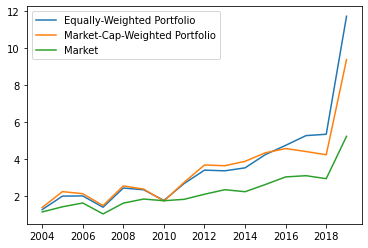

In [16]:
#視覺化
cum_ew = Return['等權重投組報酬%'].apply(lambda x: 0.01*x+1).cumprod()
cum_mw = Return['市值加權投組報酬%'].apply(lambda x: 0.01*x+1).cumprod()
cum_mkt = Return['市場報酬%'].apply(lambda x: 0.01*x+1).cumprod()
plt.plot(Return['財報年月'].dt.year,cum_ew, label = 'Equally-Weighted Portfolio')
plt.plot(Return['財報年月'].dt.year,cum_mw, label = 'Market-Cap-Weighted Portfolio')
plt.plot(Return['財報年月'].dt.year,cum_mkt, label = 'Market')
plt.legend()
plt.show()

In [17]:
#績效表格
cagr = [(cum_ew.values[-1]**(1/len(Return)) - 1)*100, (cum_mw.values[-1]**(1/len(Return)) - 1)*100,(cum_mkt.values[-1]**(1/len(Return)) - 1)*100]
std = [Return['等權重投組報酬%'].std(),Return['市值加權投組報酬%'].std() ,Return['市場報酬%'].std()]
sharpe_ratio = [(cagr[0]-1)/std[0], (cagr[1]-1)/std[1], (cagr[2]-1)/std[2],] #設rf=1%
max_dd = [100*((cum_ew/cum_ew.cummax())-1).cummin().values[-1],100*((cum_mw/cum_mw.cummax())-1).cummin().values[-1],100*((cum_mkt/cum_mkt.cummax())-1).cummin().values[-1]]
Performance =  pd.DataFrame(np.array([cagr,std,sharpe_ratio,max_dd]).reshape((4,3)),columns = ['等權重投組','市值加權投組','市場'] ,index = ['年化報酬率(%)', '年化標準差(%)','夏普比率', '最大回撤(%)'])
Performance

,等權重投組,市值加權投組,市場
年化報酬率(%),16.639020,15.024358,10.901562
年化標準差(%),38.263296,40.728159,25.575700
夏普比率,0.408721,0.344341,0.387147
最大回撤(%),-30.422158,-33.621232,-36.322100


In [18]:
watch_list_2020 = Panel[Panel['財報年月'].dt.year == 2020]['公司代碼'].tolist()[:-1] #排除市場
watch_list_2020

['1109',
 '4755',
 '1305',
 '1309',
 '5234',
 '8481',
 '2108',
 '6582',
 '5469',
 '8081']

In [19]:
firms = tejapi.get('TWN/AIND',
                  coid = watch_list_2020,
                  opts = {'columns':['coid','fnamec']},
                  paginate = True,
                  chinese_column_name = True)
firms

,公司簡稱,公司中文全稱
None,,
0,1109,信大水泥
1,1305,華夏海灣塑膠
2,1309,台達化學工業
3,2108,南帝化學工業
4,4755,三福化工
5,5234,達興材料
6,5469,瀚宇博德
7,6582,申豐特用應材
8,8081,致新科技


In [ ]:
#====================草稿區

In [115]:
test = data_cp.copy() 
test

,公司代碼,財報年月,季底普通股市值,預估稅後淨利成長率,條件1,條件2,條件3,條件4,條件5,條件6,條件7,條件8,條件9,條件10,分數
0,6168,2004-12-01,3279428.0,6463.184,1,1,0,1,1,1,1,1,1,1,9
1,1710,2004-12-01,23811603.0,46.076,0,1,1,1,1,1,1,1,1,1,9
2,3035,2004-12-01,14396534.0,34.930,1,1,1,1,1,1,1,1,1,1,10
3,6184,2004-12-01,1655400.0,85.912,1,1,1,1,1,1,1,1,1,1,10
4,8114,2004-12-01,1958662.0,214.638,1,1,1,1,1,1,1,1,1,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,5283,2020-12-01,8906000.0,21.312,1,1,0,1,1,1,1,1,1,1,9
274,5469,2020-12-01,22907917.0,168.588,1,1,1,1,1,1,1,1,0,1,9
275,4119,2020-12-01,6676740.0,16.450,1,1,0,1,1,1,1,1,1,1,9
276,3669,2020-12-01,7433520.0,310.314,1,1,0,1,1,1,1,1,1,1,9


In [116]:
data_2016 = test[test['財報年月'] == '2016-12-01']
data_2016

,公司代碼,財報年月,季底普通股市值,預估稅後淨利成長率,條件1,條件2,條件3,條件4,條件5,條件6,條件7,條件8,條件9,條件10,分數
205,3005,2016-12-01,21640519.0,39.272,1,1,1,1,1,1,1,1,0,1,9
206,2441,2016-12-01,22184955.0,21.684,1,1,0,1,1,1,1,1,1,1,9
207,1817,2016-12-01,2715240.0,17.154,1,1,0,1,1,1,1,1,1,1,9
208,1760,2016-12-01,4619784.0,79.566,1,0,1,1,1,1,1,1,1,1,9
209,2428,2016-12-01,8096678.0,16.616,1,1,0,1,1,1,1,1,1,1,9
210,2228,2016-12-01,12310025.0,19.096,1,1,0,1,1,1,1,1,1,1,9
211,5283,2016-12-01,4645539.0,109.744,1,1,1,1,1,1,1,1,0,1,9
212,1537,2016-12-01,12881138.0,27.934,1,1,1,1,1,0,1,1,1,1,9
213,8464,2016-12-01,97429150.0,34.284,0,1,1,1,1,1,1,1,1,1,9
214,1737,2016-12-01,5860000.0,25.260,1,1,1,1,1,1,1,0,1,1,9


In [117]:
stocks = data_2016['公司代碼'].tolist()
pe_ratio = tejapi.get('TWN/APRCD1',
                             coid = stocks,
                             opts = {'columns':['coid','mdate','per_tse']}, 
                             mdate = {'gte': '2016-03-31' , 'lte': '2017-03-31'},
                             paginate = True,
                             chinese_column_name = True)
pe_ratio

,證券代碼,年月日,本益比-TSE
None,,,
0,1537,2016-03-31,15.11
1,1537,2016-04-01,14.95
2,1537,2016-04-06,14.73
3,1537,2016-04-07,14.84
4,1537,2016-04-08,14.68
...,...,...,...
3180,8464,2017-03-27,22.32
3181,8464,2017-03-28,22.56
3182,8464,2017-03-29,22.32


In [125]:
stocks

['3005',
 '2441',
 '1817',
 '1760',
 '2428',
 '2228',
 '5283',
 '1537',
 '8464',
 '1737',
 '8462',
 '4952',
 '4119',
 '8341',
 '4426']

In [128]:
pe_ratio[pe_ratio['證券代碼'] == '1760']

,證券代碼,年月日,本益比-TSE
None,,,


In [129]:
pe_estimate = pe_ratio.groupby(by = '證券代碼').mean().reset_index() 
pe_estimate

,證券代碼,本益比-TSE
0,1537,14.419102
1,1737,19.065184
2,1817,11.414939
3,2228,22.165388
4,2428,10.064327
5,2441,10.748449
6,3005,13.736082
7,4119,14.764041
8,4426,18.145143
9,4952,10.318939


In [130]:
relative_performance = tejapi.get('TWN/APRCD2',
                             coid = stocks,
                             opts = {'columns':['coid','mdate','rois_m', 'rois_y']}, 
                             mdate = {'gte': '2017-03-20' , 'lte': '2017-03-31'}, #=========================減少撈取輛
                             paginate = True,
                             chinese_column_name = True)
relative_performance 

,證券代碼,年月日,超額報酬(月)-大盤,超額報酬(年)-大盤
None,,,,
0,1537,2017-03-20,0.6056,4.5866
1,1537,2017-03-21,1.4240,3.8945
2,1537,2017-03-22,3.0743,6.5101
3,1537,2017-03-23,3.9399,6.6420
4,1537,2017-03-24,5.3440,9.0299
...,...,...,...,...
145,8464,2017-03-27,-7.7844,8.0623
146,8464,2017-03-28,-6.7829,9.1736
147,8464,2017-03-29,-7.5740,8.9643


In [131]:
relative_performance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   證券代碼        150 non-null    object        
 1   年月日         150 non-null    datetime64[ns]
 2   超額報酬(月)-大盤  130 non-null    float64       
 3   超額報酬(年)-大盤  130 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 4.8+ KB


In [133]:
relative = relative_performance.groupby(by = '證券代碼').last().reset_index()
relative

,證券代碼,年月日,超額報酬(月)-大盤,超額報酬(年)-大盤
0,1537,2017-03-31,2.9925,4.2448
1,1737,2017-03-31,-2.7227,-2.8884
2,1760,2017-03-31,NaN,NaN
3,1817,2017-03-31,2.8407,-10.0041
4,2228,2017-03-31,-3.4114,-21.1271
5,2428,2017-03-31,-2.2413,19.3501
6,2441,2017-03-31,-0.8656,7.8023
7,3005,2017-03-31,0.7695,97.5918
8,4119,2017-03-31,-2.9636,-14.2662
9,4426,2017-03-31,-10.8163,-54.5220


In [139]:
merge = pe_estimate.merge(relative, on = '證券代碼')
merge

,證券代碼,本益比-TSE,年月日,超額報酬(月)-大盤,超額報酬(年)-大盤
0,1537,14.419102,2017-03-31,2.9925,4.2448
1,1737,19.065184,2017-03-31,-2.7227,-2.8884
2,1817,11.414939,2017-03-31,2.8407,-10.0041
3,2228,22.165388,2017-03-31,-3.4114,-21.1271
4,2428,10.064327,2017-03-31,-2.2413,19.3501
5,2441,10.748449,2017-03-31,-0.8656,7.8023
6,3005,13.736082,2017-03-31,0.7695,97.5918
7,4119,14.764041,2017-03-31,-2.9636,-14.2662
8,4426,18.145143,2017-03-31,-10.8163,-54.5220
9,4952,10.318939,2017-03-31,1.2329,-7.9622


In [140]:
merge = merge.rename(columns = {'證券代碼':'公司代碼', '本益比-TSE':'預估本益比'})
merge

,公司代碼,預估本益比,年月日,超額報酬(月)-大盤,超額報酬(年)-大盤
0,1537,14.419102,2017-03-31,2.9925,4.2448
1,1737,19.065184,2017-03-31,-2.7227,-2.8884
2,1817,11.414939,2017-03-31,2.8407,-10.0041
3,2228,22.165388,2017-03-31,-3.4114,-21.1271
4,2428,10.064327,2017-03-31,-2.2413,19.3501
5,2441,10.748449,2017-03-31,-0.8656,7.8023
6,3005,13.736082,2017-03-31,0.7695,97.5918
7,4119,14.764041,2017-03-31,-2.9636,-14.2662
8,4426,18.145143,2017-03-31,-10.8163,-54.5220
9,4952,10.318939,2017-03-31,1.2329,-7.9622


In [142]:
merge = data_2016.merge(merge[['公司代碼', '預估本益比','超額報酬(月)-大盤','超額報酬(年)-大盤']], on = '公司代碼') 
merge

,公司代碼,財報年月,季底普通股市值,預估稅後淨利成長率,條件1,條件2,條件3,條件4,條件5,條件6,條件7,條件8,條件9,條件10,分數,預估本益比,超額報酬(月)-大盤,超額報酬(年)-大盤
0,3005,2016-12-01,21640519.0,39.272,1,1,1,1,1,1,1,1,0,1,9,13.736082,0.7695,97.5918
1,2441,2016-12-01,22184955.0,21.684,1,1,0,1,1,1,1,1,1,1,9,10.748449,-0.8656,7.8023
2,1817,2016-12-01,2715240.0,17.154,1,1,0,1,1,1,1,1,1,1,9,11.414939,2.8407,-10.0041
3,2428,2016-12-01,8096678.0,16.616,1,1,0,1,1,1,1,1,1,1,9,10.064327,-2.2413,19.3501
4,2228,2016-12-01,12310025.0,19.096,1,1,0,1,1,1,1,1,1,1,9,22.165388,-3.4114,-21.1271
5,1537,2016-12-01,12881138.0,27.934,1,1,1,1,1,0,1,1,1,1,9,14.419102,2.9925,4.2448
6,8464,2016-12-01,97429150.0,34.284,0,1,1,1,1,1,1,1,1,1,9,30.039061,-6.4497,14.1814
7,1737,2016-12-01,5860000.0,25.260,1,1,1,1,1,1,1,0,1,1,9,19.065184,-2.7227,-2.8884
8,8462,2016-12-01,3385858.0,45.878,1,1,1,1,1,1,1,1,0,1,9,23.280531,3.0389,20.5467
9,4952,2016-12-01,4064240.0,73.828,1,1,0,1,1,1,1,1,1,1,9,10.318939,1.2329,-7.9622


In [143]:
#新欄位: 預估本益比與成長率比值 (PEG)
merge['預估本益比與成長率比值'] = merge['預估本益比']/merge['預估稅後淨利成長率']
merge

,公司代碼,財報年月,季底普通股市值,預估稅後淨利成長率,條件1,條件2,條件3,條件4,條件5,...,條件7,條件8,條件9,條件10,分數,預估本益比,超額報酬(月)-大盤,超額報酬(年)-大盤,預估本益比與成長率比值
0,3005,2016-12-01,21640519.0,39.272,1,1,1,1,1,...,1,1,0,1,9,13.736082,0.7695,97.5918,0.349768
1,2441,2016-12-01,22184955.0,21.684,1,1,0,1,1,...,1,1,1,1,9,10.748449,-0.8656,7.8023,0.495686
2,1817,2016-12-01,2715240.0,17.154,1,1,0,1,1,...,1,1,1,1,9,11.414939,2.8407,-10.0041,0.665439
3,2428,2016-12-01,8096678.0,16.616,1,1,0,1,1,...,1,1,1,1,9,10.064327,-2.2413,19.3501,0.605701
4,2228,2016-12-01,12310025.0,19.096,1,1,0,1,1,...,1,1,1,1,9,22.165388,-3.4114,-21.1271,1.160735
5,1537,2016-12-01,12881138.0,27.934,1,1,1,1,1,...,1,1,1,1,9,14.419102,2.9925,4.2448,0.516185
6,8464,2016-12-01,97429150.0,34.284,0,1,1,1,1,...,1,1,1,1,9,30.039061,-6.4497,14.1814,0.876183
7,1737,2016-12-01,5860000.0,25.260,1,1,1,1,1,...,1,0,1,1,9,19.065184,-2.7227,-2.8884,0.754758
8,8462,2016-12-01,3385858.0,45.878,1,1,1,1,1,...,1,1,0,1,9,23.280531,3.0389,20.5467,0.507444
9,4952,2016-12-01,4064240.0,73.828,1,1,0,1,1,...,1,1,1,1,9,10.318939,1.2329,-7.9622,0.139770


In [144]:
#交易面條件篩選，得到最終投組的成分
final = merge[(merge['預估本益比'] <= 20)&(merge['預估本益比與成長率比值'] <= 1.2) & (merge['超額報酬(月)-大盤'] > 0) &(merge['超額報酬(年)-大盤'] > 0)].reset_index(drop=True)
final

,公司代碼,財報年月,季底普通股市值,預估稅後淨利成長率,條件1,條件2,條件3,條件4,條件5,...,條件7,條件8,條件9,條件10,分數,預估本益比,超額報酬(月)-大盤,超額報酬(年)-大盤,預估本益比與成長率比值
0,3005,2016-12-01,21640519.0,39.272,1,1,1,1,1,...,1,1,0,1,9,13.736082,0.7695,97.5918,0.349768
1,1537,2016-12-01,12881138.0,27.934,1,1,1,1,1,...,1,1,1,1,9,14.419102,2.9925,4.2448,0.516185


In [ ]:
#改欄位名，以利合併與辨識
pe_estimate = pe_estimate.rename(columns = {'證券代碼':'公司代碼', '本益比-TSE':'預估本益比'})
merge = data_2016.merge(pe_estimate[['公司代碼','預估本益比']], on = '公司代碼')
merge

In [ ]:
#新欄位: 預估本益比與成長率比值 (PEG)
merge['預估本益比與成長率比值'] = merge['預估本益比']/merge['預估稅後淨利成長率']
    
#交易面條件篩選，得到最終投組的成分
final = merge[(merge['預估本益比'] <= 20)&(merge['預估本益比與成長率比值'] <= 1.2)].reset_index(drop=True)

#新欄位: 計算成分股於投組內的市值權重，用於計算市值加權報酬
final['權重']  = final['季底普通股市值']/ final['季底普通股市值'].sum() 
final

In [ ]:
#=========================

In [84]:
Panel = pd.DataFrame()        #儲存每檔股票的完整資訊
Return = pd.DataFrame()       #儲存投組報酬率
date_list = pd.DatetimeIndex(data_cp['財報年月'].unique()) #儲存日期，並轉成DatatimeIndex序列。為了使用 .year提取年份功能

for date in date_list: 
    #每一年產生一張dataframe
    table = data_cp[data_cp['財報年月'].dt.year == date.year].reset_index(drop=True)
    
    #取得建構投組時，成分股的前一年本益比，進行第二階段篩選
    stocks = table['公司代碼'].tolist()
    pe_ratio = tejapi.get('TWN/APRCD1',
                             coid = stocks,
                             opts = {'columns':['coid','mdate','per_tse']}, 
                             mdate = {'gte': date + pd.Timedelta(days = 120 - 365) , 'lte': date + pd.Timedelta(days = 120)},
                             paginate = True,
                             chinese_column_name = True)
    
    #計算過去一年平均本益比，當作預估
    pe_estimate = pe_ratio.groupby(by = '證券代碼').mean().reset_index() 
    
    #改欄位名，以利合併與辨識
    pe_estimate = pe_estimate.rename(columns = {'證券代碼':'公司代碼', '本益比-TSE':'預估本益比'})
    merge = table.merge(pe_estimate[['公司代碼','預估本益比']], on = '公司代碼')
    
    #新欄位: 預估本益比與成長率比值 (PEG)
    merge['預估本益比與成長率比值'] = merge['預估本益比']/merge['預估稅後淨利成長率']
    
    #交易面條件篩選，得到最終投組的成分
    final = merge[(merge['預估本益比'] <= 20)&(merge['預估本益比與成長率比值'] <= 1.2)].reset_index(drop=True)
    
    #新欄位: 計算成分股於投組內的市值權重，用於計算市值加權報酬
    final['權重']  = final['季底普通股市值']/ final['季底普通股市值'].sum() 
    
    #撈取該年成分股、市場的年報酬
    stocks = final['公司代碼'].tolist()
    ret = tejapi.get('TWN/APRCD2',
            coid = stocks + ['Y9997'], 
            paginate = True,
            opts = {'columns':['coid','mdate','roi_y']}, 
            mdate = {'gte': date + pd.Timedelta(days = 120), 'lte': date + pd.Timedelta(days = 120+365)}, 
            chinese_column_name = True)
    
    #期間報酬率: 取得這段期間的最後一筆，即為持有成分股這一年的報酬率
    period_ret = ret.groupby(by = '證券代碼')['年報酬率 %'].last().reset_index()
    
    #賦予日期、改變欄名以利合併
    period_ret['財報年月'] = date 
    period_ret = period_ret.rename(columns = {'證券代碼':'公司代碼'})  
    
    #將final表與期間報酬合併, outer保留市場資料
    temp = final.merge(period_ret,on = ['公司代碼','財報年月'], how = 'outer')
    
    #儲存每年的完整資料
    Panel = Panel.append(temp).reset_index(drop=True)
    
    if 2020 > date.year >= 2004:  #2005年才開始持有投組，且排除2020年，因為由2020年財務數據建構的投組尚未持有一年
        #計算投組報酬率、市場報酬率
        fee = 0.1425*2 + 0.3
        eq_port = temp.loc[:,'年報酬率 %'].values[:-1].mean() - fee        #投組平均加權報酬率，不要算到市場報酬
        val_port = (temp['權重']*temp['年報酬率 %']).dropna().sum() - fee  #投組市值加權報酬率  (去掉na 是為了排除市場報酬)
        mkt = temp['年報酬率 %'].values[-1]                                #市場報酬
        #儲存報酬率
        Return = Return.append(pd.DataFrame(np.array([date,eq_port,val_port,mkt]).reshape((1,4)),columns = ['財報年月','等權重投組報酬%','市值加權投組報酬%','市場報酬%'])).reset_index(drop=True)
        

In [89]:
Panel

,公司代碼,財報年月,季底普通股市值,預估稅後淨利成長率,條件1,條件2,條件3,條件4,條件5,...,條件7,條件8,條件9,條件10,分數,預估本益比,預估本益比與成長率比值,權重,年報酬率 %
0,6168,2004-12-01,3279428.0,6463.184,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,9.0,9.426360,0.001458,0.006610,18.5052
1,1710,2004-12-01,23811603.0,46.076,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,9.0,10.396680,0.225642,0.047995,-23.7041
2,3035,2004-12-01,14396534.0,34.930,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,10.0,12.219280,0.349822,0.029018,-1.2533
3,6184,2004-12-01,1655400.0,85.912,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,10.0,7.705720,0.089693,0.003337,12.7557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,5469,2020-12-01,22907917.0,168.588,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,9.0,7.621755,0.045209,0.113624,-14.1665
224,4119,2020-12-01,6676740.0,16.450,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,9.0,14.655633,0.890920,0.033117,-28.5256
225,8081,2020-12-01,13744434.0,25.224,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,9.0,15.379429,0.609714,0.068173,61.1153
226,Y9997,2020-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.7264


In [92]:
Return

,財報年月,等權重投組報酬%,市值加權投組報酬%,市場報酬%
0,2004-12-01,14.2643,5.24861,14.5479
1,2005-12-01,65.5568,64.261,24.1618
2,2006-12-01,8.44388,5.22681,14.5676
3,2007-12-01,-29.5906,-30.8303,-36.3221
4,2008-12-01,60.4239,53.1301,56.2553
5,2009-12-01,7.84465,2.11844,13.6326
6,2010-12-01,3.70419,1.47997,-4.9297
7,2011-12-01,24.8975,10.8515,4.3437
8,2012-12-01,27.8547,33.9121,15.046
9,2013-12-01,-8.20182,-15.2028,11.6488


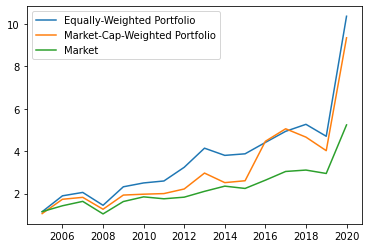

In [60]:
#視覺化
cum_ew = Return['等權重投組報酬%'].apply(lambda x: 0.01*x+1).cumprod()
cum_mw = Return['市值加權投組報酬%'].apply(lambda x: 0.01*x+1).cumprod()
cum_mkt = Return['市場報酬%'].apply(lambda x: 0.01*x+1).cumprod()
plt.plot(Return['財報年月'].dt.year+1,cum_ew, label = 'Equally-Weighted Portfolio')
plt.plot(Return['財報年月'].dt.year+1,cum_mw, label = 'Market-Cap-Weighted Portfolio')
plt.plot(Return['財報年月'].dt.year+1,cum_mkt, label = 'Market')
plt.legend()
plt.show()

In [61]:
#績效表格
cagr = [(cum_ew.values[-1]**(1/len(Return)) - 1)*100, (cum_mw.values[-1]**(1/len(Return)) - 1)*100,(cum_mkt.values[-1]**(1/len(Return)) - 1)*100]
std = [Return['等權重投組報酬%'].std(),Return['市值加權投組報酬%'].std() ,Return['市場報酬%'].std()]
sharpe_ratio = [(cagr[0]-1)/std[0], (cagr[1]-1)/std[1], (cagr[2]-1)/std[2],] #設rf=1%
max_dd = [100*((cum_ew/cum_ew.cummax())-1).cummin().values[-1],100*((cum_mw/cum_mw.cummax())-1).cummin().values[-1],100*((cum_mkt/cum_mkt.cummax())-1).cummin().values[-1]]

Performance =  pd.DataFrame(np.array([cagr,std,sharpe_ratio,max_dd]).reshape((4,3)),columns = ['等權重投組','市值加權投組','市場'] ,index = ['年化報酬率(%)', '年化標準差(%)','夏普比率', '最大回撤(%)'])  

In [62]:
Performance

,等權重投組,市值加權投組,市場
年化報酬率(%),15.735439,14.991415,10.901562
年化標準差(%),35.849070,41.450101,25.575700
夏普比率,0.411041,0.337548,0.387147
最大回撤(%),-29.590592,-30.830299,-36.322100


In [93]:
#2020成分股
watch_list_2020 = Panel[Panel['財報年月'].dt.year == 2020]['公司代碼'].tolist()[:-1] #排除市場
watch_list_2020

['1109',
 '4755',
 '1305',
 '1309',
 '3533',
 '5234',
 '8481',
 '2108',
 '6582',
 '5283',
 '5469',
 '4119',
 '8081']

In [94]:
#查詢
firms = tejapi.get('TWN/AIND',
                  coid = watch_list_2020,
                  opts = {'columns':['coid','fnamec']},
                  paginate = True,
                  chinese_column_name = True)
firms

,公司簡稱,公司中文全稱
None,,
0,1109,信大水泥
1,1305,華夏海灣塑膠
2,1309,台達化學工業
3,2108,南帝化學工業
4,3533,嘉澤端子工業
5,4119,旭富製藥科技
6,4755,三福化工
7,5234,達興材料
8,5283,禾聯碩
